# Embeddings: Converting text into numbers

## ML Models operate on numerical data
Recall from last week that neural networks operate on tensors. They cannot directly process raw text. If this is the case, how can we pass in a sentence into a transformer?

We need a way to convert strings into tensors in a way that:
1. Preserves semantic meaning (e.g the underlying meaning of the words)
2. Captures relationships between words and characters ("Joe" comes before "Biden").

To embed text, we need to create two components:
1. The tokenizer: Splits your text into "tokens", or atomic elements that we convert into vectors. If we have the sentence "Lobsters are tasty", a valid tokenization would be ["Lobsters","are","tasty"]. Alternatively, we might tokenize by character, yielding ["L","o","b","s"...]. Modern large language models use more complex tokenization schemes that account for optimal encoding of common strings (such that the most frequently-used phrases are tokenized into single tokens). Those of you familiar with Huffman encoding may find the type of encoding we'll implement later on in the quarter, [Byte Pair Encoding](https://huggingface.co/learn/nlp-course/en/chapter6/5), similar. Don't worry if you're not familiar with this for now. The tokenizer converts text into [one-hot vectors](https://en.wikipedia.org/wiki/One-hot).
2. The embedding layer: Projects the one-hot encoded vectors into a fixed-dimensional vector space.

### Tokenization
Examples:

- Word-level: "I love machine learning" -> ["I", "love", "machine", "learning"]
- Character-level: "Hello" -> ["H", "e", "l", "l", "o"]
- Subword-level: "unbelievable" -> ["un", "believe", "able"]

For the sake of simplicity, we'll use character-level tokenization.

In [ ]:
import torch
from typing import List
from torch.nn import functional as F

vocab = """abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ., '\""()[]!?"""

# Exercise 1:
def tokenize(text: str) -> List[str]:
    # TODO: Split text into tokens. Your output should be a list of tokens.
    # For this task, you should be sure to encode all characters from a-z and A-Z, as well as [. , ' " () ]. I've provided the list above.
    return [char for char in text if char in vocab]

text = "Hello, World!"
tokens = tokenize(text)
print("Tokens:", tokens)

Now, we want to convert the list of tokens into orthogonal vectors in a high-dimensional space. As an example, if we only had the letters "a", "b", and "c", we can encode "a" as [1, 0, 0], "b" as [0, 1, 0], and "c" as [0, 0, 1]. As a reminder, orthogonal vectors are perpendicular to each other; if you were to take the dot product between two orthogonal vectors, you would get zero. Right now, these orthogonal representations mean that the representations of each character is completely independent of the representations of the others. This isn't the final behavior we want to have; we'd like text with similar meanings to have vectors that are closer to each other in the high-dimensional space. 

Food for thought: Why would we want to have that?

### Reading Documentation
Frequently when writing your own ML code, you'll have to read documentation provided by `pytorch`, `huggingface`, or your preferred framework. Here's an easy example to get started:
Read [the documentation](https://pytorch.org/docs/stable/generated/torch.nn.functional.one_hot.html) of torch's `functional.one_hot` function. I've written out the code that converts your tokens into a list of numerical indices; if you had ['a','b','c'], now you'll have [1,2,3]. Can you transform this into a 2D tensor of orthogonal vectors using `functional.one_hot`? 

Feel free to ask us for help!

In [ ]:
char_to_index = {char: idx for idx, char in enumerate(vocab)}
index_to_char = {idx: char for char, idx in char_to_index.items()}

def vectorize(tokens: List[str]) -> torch.Tensor:
    indices = torch.tensor([char_to_index[char] for char in tokens])
    # TODO: Convert this list of indices into an orthogonal vector.
    return F.one_hot(indices, num_classes=len(vocab)).float()
    
def detokenize(tensor: torch.Tensor):
    indices = tensor.argmax(dim=-1).tolist()
    return ''.join(index_to_char[idx] for idx in indices)

text = "Hello, World!"
tokens = tokenize(text)
print("Tokens:", tokens)

vector = vectorize(tokens)
print("Vector shape:", vector.shape)

reconstructed_text = detokenize(vector)
print("Reconstructed text:", reconstructed_text)

assert text == reconstructed_text

### Embedding Layer
The embedding layer is a linear projection of your one-hot vectors into a shared dimensional space. Its job is to **add meaning**: to convert the token representations into vectors that contain meaning.

Ideally, the delta between representations is meaningful. In the image below, if you did the vector operation `woman - girl + boy`, you'd get a vector close in vector space to `man`. 

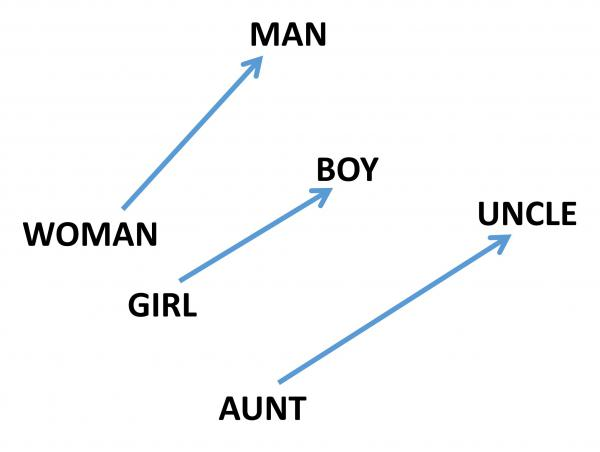

The core idea within the transformer architecture is that **vectors represent semantics**. At each layer of a transformer, attention heads act to process relationships between vectors at different token positions, while MLPs act to transform vectors within the same token position. Don't worry about this for now: We'll get more into it later. 

In [ ]:
# Exercise: Write a class that inherits from nn.Module that projects vectors from a tensor into a given dimensionality. 

import torch.nn as nn
# TODO: Create the EmbeddingProjection class.
# If you need review, look at last week's notebook.
# Note: Turn bias off in your linear layer!
# ----------------------
class EmbeddingProjection(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int):
        super().__init__()
        self.projection = nn.Linear(vocab_size, embedding_dim, bias=False)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.projection(x)
        
# Your class is initialized like so:

vocab_size = len(vocab)  # Size of our character vocabulary
embedding_dim = 16  # Desired embedding dimensionality
embedding_proj = EmbeddingProjection(vocab_size, embedding_dim)
        
# Test cases:
batch_size = 2
sequence_length = 5
sample_input = torch.randn(batch_size, sequence_length, vocab_size)
projected_embedding = embedding_proj(sample_input)

print(f"Input shape: {sample_input.shape}")
print(f"Projected embedding shape: {projected_embedding.shape}")

assert projected_embedding.shape == (batch_size, sequence_length, embedding_dim), "Output shape is incorrect"
print("Shape verification passed!")

Now that we've created our embedding layer, let's try training it!

Don't worry about implementing the code below, though ask us if you have any questions about what each step is doing.

In [ ]:
import math

class SmallTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_layers):
        super().__init__()
        self.embedding = EmbeddingProjection(vocab_size, d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=512, dropout=0.05)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.d_model = d_model
        self.linear = nn.Linear(d_model, vocab_size)

    def forward(self, src, src_mask):
        src = self.embedding(src) * math.sqrt(self.d_model)
        output = self.transformer_encoder(src, src_mask)
        output = self.linear(output)
        return output

# Initialize the model
vocab_size = len(vocab)  
d_model = 128
nhead = 4
num_layers = 2
model = SmallTransformer(vocab_size, d_model, nhead, num_layers)
print(model)

In [ ]:
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import requests
import io
import random

class TextDataset(Dataset):
    def __init__(self, text, seq_length):
        self.text = text
        self.seq_length = seq_length
        self.tokens = tokenize(text)

    def __len__(self):
        return len(self.tokens) - self.seq_length

    def __getitem__(self, idx):
        input_seq = self.tokens[idx:idx+self.seq_length]
        target_seq = self.tokens[idx+1:idx+self.seq_length+1]
        return vectorize(input_seq), vectorize(target_seq)

# Download toy data (Shakespeare sonnets)
url = "https://www.gutenberg.org/files/1041/1041-0.txt"
response = requests.get(url)
text = response.text.split("THE SONNETS", 1)[1].split("End of the Project Gutenberg EBook", 1)[0]

# Prepare the dataset
seq_length = 32
dataset = TextDataset(text, seq_length)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize the model, loss function, and optimizer
model = SmallTransformer(vocab_size, d_model, nhead, num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch, (input_seq, target_seq) in enumerate(dataloader):
        input_seq, target_seq = input_seq.to(device), target_seq.to(device)
        
        optimizer.zero_grad()
        
        # Create mask to hide future tokens
        
        src_mask = nn.Transformer.generate_square_subsequent_mask(input_seq.size(0)).to(device)
        
        output = model(input_seq, src_mask)
        loss = criterion(output, target_seq)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch % 100 == 0:
            print(f"Epoch {epoch+1}, Batch {batch}, Loss: {loss.item():.4f}")
    
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1} completed. Average Loss: {avg_loss:.4f}")

In [ ]:
# Generate some text
model.eval()
start_text = "Shall I compare thee to a summer's day?"
input_seq = torch.tensor(vectorize(tokenize(start_text))).unsqueeze(0).to(device)
generated_text = start_text

with torch.no_grad():
    for _ in range(100):
        src_mask = nn.Transformer.generate_square_subsequent_mask(input_seq.size(0)).to(device)
        output = model(input_seq, src_mask)
        next_char_index = output[0, -1, :].argmax().item()
        next_char = index_to_char[next_char_index]
        generated_text += next_char
        input_seq = torch.cat([input_seq, output[:, -1, :].unsqueeze(1)], dim=1)

print("Generated text:")
print(generated_text)

This sucks. The reason why is that we're lacking:
## Positional Encodings

Now that we've tokenized our text and represented each token as an orthogonal vector, we need to consider an important aspect of language: the order of words matters. In the current representation, the model has no way of knowing the position of each token in the sequence. For instance, "The cat sat on the mat" and "The mat sat on the cat" would be represented identically, despite having very different meanings!

This is where positional embeddings come in, allowing us to inject information about the position of each token into its representation. But how do we do this?

One clever solution is sinusoidal positional embeddings. The idea is to add a unique positional vector to each token's embedding. These positional vectors are created using sine and cosine functions of different frequencies. Here's why this works so well:

1. It can handle variable length sequences.
2. It allows the model to easily learn to attend to relative positions.
3. The pattern can be extrapolated to sequences longer than those seen during training.

Here's a simplified implementation of sinusoidal positional embeddings:

In [ ]:
import torch
import math
import seaborn as sns

def positional_encoding(seq_len, d_model):
    position = torch.arange(seq_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
    pos_encoding = torch.zeros(seq_len, d_model)
    pos_encoding[:, 0::2] = torch.sin(position * div_term)
    pos_encoding[:, 1::2] = torch.cos(position * div_term)
    return pos_encoding

sns.heatmap(positional_encoding(50, 20).T)

This function creates a unique positional encoding for each position in the sequence. When we add this to our token embeddings, each token now carries information about both its identity and its position in the sequence.

To make use of these positional embeddings, we simply add them to the semantic embeddings (created by your linear projection in the embedding layer) at each token position.

In the plot above, notice how at each token position (vertical column), the striping pattern is different and varies depending on the position. An interesting element to note about sinusoidal embeddings is that you can transform the embedding at a given position to the embedding at another position fairly easily using a single matrix transform. There's a significant amount of theory about positional embeddings and their functionality; if you're interested, I encourage you read [Relative Positional Embeddings](https://jaketae.github.io/study/relative-positional-encoding/) by Jake Tae.

In [37]:
# Bonus Exercise: Retrain your transformer, but with PE!